In [2]:
import torch
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import evaluate
import faiss
warnings.filterwarnings('ignore')

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
wikipedia_text_corpus = load_dataset('rag-datasets/rag-mini-wikipedia', 'text-corpus')
wikipedia_question_answer = load_dataset('rag-datasets/rag-mini-wikipedia', 'question-answer')

print(f"Wikipedia corpus size: {len(wikipedia_text_corpus['passages'])}")
print(f"Wikipedia Q&A test: {len(wikipedia_question_answer['test'])}")

Wikipedia corpus size: 3200
Wikipedia Q&A test: 918


In [5]:
kb_documents = [doc['passage'] for doc in wikipedia_text_corpus['passages']]
print(f"Total KB documents: {len(kb_documents)}")

Total KB documents: 3200


In [6]:
embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
batch_size = 1000
kb_embeddings = []

for i in tqdm(range(0, len(kb_documents), batch_size)):
    batch = kb_documents[i:i + batch_size]
    embeddings = embedding_model.encode(batch, show_progress_bar=False)
    kb_embeddings.append(embeddings)

kb_embeddings = np.vstack(kb_embeddings).astype('float32')
print(f"Embeddings shape: {kb_embeddings.shape}")

100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

Embeddings shape: (3200, 384)


*FAISS for fast semantic similarity search over KB embeddings (with vector normalization)*

In [7]:
dimension = kb_embeddings.shape[1]
index = faiss.IndexFlatIP(dimension)
faiss.normalize_L2(kb_embeddings)
index.add(kb_embeddings)
print(f"Index created with {index.ntotal} vectors")

Index created with 3200 vectors


In [8]:
def retrieve_context(query, top_k=5, similarity_threshold=0.5):
    query_embedding = embedding_model.encode([query], show_progress_bar=False).astype('float32')
    faiss.normalize_L2(query_embedding)

    distances, indices = index.search(query_embedding, top_k * 2)

    filtered_docs = []
    filtered_scores = []

    for dist, idx in zip(distances[0], indices[0]):
        if dist >= similarity_threshold:
            filtered_docs.append(kb_documents[idx])
            filtered_scores.append(dist)

        if len(filtered_docs) >= top_k:
            break

    return filtered_docs, filtered_scores

In [9]:
test_question = wikipedia_question_answer['test'][0]['question']
print(f"Test question: {test_question}")
retrieved, scores = retrieve_context(test_question, top_k=5)
print(f"Retrieved documents:")
for i, (doc, score) in enumerate(zip(retrieved, scores)):
    print(f"{i + 1}. (score: {score:.2f}) {doc[:100]}...")

Test question: Was Abraham Lincoln the sixteenth President of the United States?
Retrieved documents:
1. (score: 0.71) Young Abraham Lincoln...
2. (score: 0.58) Abraham Lincoln (February 12, 1809 â April 15, 1865) was the sixteenth President of the United Sta...
3. (score: 0.56) Sixteen months before his death, his son, John Quincy Adams, became the sixth President of the Unite...
4. (score: 0.56) * His earliest memory, from age 3, was of hearing that Abraham Lincoln had been elected and that a w...
5. (score: 0.55) On November 6, 1860, Lincoln was elected as the 16th President of the United States, beating Democra...


In [10]:
model_name = 'meta-llama/Llama-2-7b-chat-hf'

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map='auto',
    trust_remote_code=True
)
model.eval()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMS

In [21]:
def create_prompt_with_rag(question, context_docs=None):
    if context_docs is None or len(context_docs) == 0:
        # Zero-shot without context
        prompt = f"""Answer the following question based on your knowledge.

Question: {question}

Provide a concise and factual answer.

Answer:"""
    else:
        # RAG with context
        context = '\n'.join([f"- {doc}" for doc in context_docs])
        prompt = f"""Use the following context to answer the question.

Context:
{context}

Question: {question}

Based ONLY on the context above, provide a concise factual answer. "

Answer:"""

    return prompt

In [25]:
def generate_answer(prompt, max_new_tokens=30):
    inputs = tokenizer(
        prompt,
        return_tensors='pt',
        truncation=True,
        max_length=2048,
        padding=True
    ).to(device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.1,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    prompt_length = len(tokenizer.decode(inputs['input_ids'][0], skip_special_tokens=True))
    generated_text = response[prompt_length:].strip()

    lower_text = generated_text.lower()

    # Yes/No filtering
    if lower_text.startswith('yes'):
        return 'yes'
    elif lower_text.startswith('no'):
        return 'no'

    return generated_text

In [13]:
test_data = wikipedia_question_answer['test']
print(f"Test set length: {len(test_data)}")

n_samples = 200
test_data = test_data.select(range(min(n_samples, len(test_data))))
print(f"Testing data length: {len(test_data)}")

Test set length: 918
Testing data length: 200


In [14]:
bleu = evaluate.load("bleu")
bertscore = evaluate.load("bertscore")

In [27]:
context_sizes = [0, 3, 5, 10]
results = []

for n_context in context_sizes:
    print(f"Evaluating with {n_context} context documents")

    predictions = []
    references = []

    for i, example in enumerate(tqdm(test_data, desc=f"{n_context}-context")):
        question = example['question']
        correct_answer = example['answer']

        if n_context > 0:
            context_docs, _ = retrieve_context(question, top_k=n_context, similarity_threshold=0.4)
        else:
            context_docs = None

        prompt = create_prompt_with_rag(question, context_docs)
        generated_answer = generate_answer(prompt)

        predictions.append(generated_answer)
        references.append(correct_answer)

        if i < 10:
            print(f"Example {i+1}:")
            print(f"Question: {question[:80]}...")
            print(f"Generated: {generated_answer[:50]}...")
            print(f"Correct: {correct_answer}")

    try:
        bleu_score = bleu.compute(
            predictions=predictions,
            references=[[r] for r in references],
            smooth=True
        )['bleu']
    except:
        bleu_score = 0.0

    try:
        bert_results = bertscore.compute(
            predictions=predictions,
            references=references,
            lang='en',
            model_type='roberta-large'
        )
        bert_f1 = float(np.mean(bert_results['f1']))
    except:
        bert_f1 = 0.0

    results.append({
        'n_context': n_context,
        'bleu': bleu_score,
        'bertscore_f1': bert_f1,
        'predictions': predictions,
        'references': references
    })

    print(f"{n_context} context documents:")
    print(f"BLEU: {bleu_score:.4f}")
    print(f"BERTScore F1: {bert_f1:.4f}")

Evaluating with 0 context documents


0-context:   0%|          | 1/200 [00:02<08:37,  2.60s/it]

Example 1:
Question: Was Abraham Lincoln the sixteenth President of the United States?...
Generated: no...
Correct: yes


0-context:   1%|          | 2/200 [00:05<08:15,  2.50s/it]

Example 2:
Question: Did Lincoln sign the National Banking Act of 1863?...
Generated: Lincoln did not sign the National Banking Act of 1...
Correct: yes


0-context:   2%|▏         | 3/200 [00:07<07:40,  2.34s/it]

Example 3:
Question: Did his mother die of pneumonia?...
Generated: no...
Correct: no


0-context:   2%|▏         | 4/200 [00:09<07:41,  2.35s/it]

Example 4:
Question: How many long was Lincoln's formal education?...
Generated: Abraham Lincoln had a total of 18 months of formal...
Correct: 18 months


0-context:   2%|▎         | 5/200 [00:11<07:42,  2.37s/it]

Example 5:
Question: When did Lincoln begin his political career?...
Generated: Lincoln began his political career in 1832, when h...
Correct: 1832


0-context:   3%|▎         | 6/200 [00:14<07:36,  2.35s/it]

Example 6:
Question: What did The Legal Tender Act of 1862 establish?...
Generated: The Legal Tender Act of 1862 established that all ...
Correct: the United States Note, the first paper currency in United States history


0-context:   4%|▎         | 7/200 [00:16<07:33,  2.35s/it]

Example 7:
Question: Who suggested Lincoln grow a beard?...
Generated: The suggestion to grow a beard was made by Joshua ...
Correct: 11-year-old Grace Bedell


0-context:   4%|▍         | 8/200 [00:18<07:33,  2.36s/it]

Example 8:
Question: When did the Gettysburg address argue that America was born?...
Generated: The Gettysburg Address did not argue that America ...
Correct: 1776


0-context:   4%|▍         | 9/200 [00:21<07:25,  2.33s/it]

Example 9:
Question: Did Lincoln beat John C. Breckinridge in the 1860 election?...
Generated: no...
Correct: yes


0-context:   5%|▌         | 10/200 [00:23<07:24,  2.34s/it]

Example 10:
Question: Was Abraham Lincoln the first President of the United States?...
Generated: no...
Correct: No


5-context: 100%|██████████| 200/200 [06:50<00:00,  2.05s/it]


5 context documents:
BLEU: 0.1017
BERTScore F1: 0.9140
Evaluating with 10 context documents


10-context:   0%|          | 1/200 [00:02<08:45,  2.64s/it]

Example 1:
Question: Was Abraham Lincoln the sixteenth President of the United States?...
Generated: yes...
Correct: yes


10-context:   1%|          | 2/200 [00:05<08:53,  2.70s/it]

Example 2:
Question: Did Lincoln sign the National Banking Act of 1863?...
Generated: no...
Correct: yes


10-context:   2%|▏         | 3/200 [00:08<08:45,  2.67s/it]

Example 3:
Question: Did his mother die of pneumonia?...
Generated: no...
Correct: no


10-context:   2%|▏         | 4/200 [00:09<07:18,  2.24s/it]

Example 4:
Question: How many long was Lincoln's formal education?...
Generated: Lincoln's formal education lasted for about 18 mon...
Correct: 18 months


10-context:   2%|▎         | 5/200 [00:12<07:51,  2.42s/it]

Example 5:
Question: When did Lincoln begin his political career?...
Generated: Lincoln began his political career in 1832, at the...
Correct: 1832


10-context:   3%|▎         | 6/200 [00:14<07:45,  2.40s/it]

Example 6:
Question: What did The Legal Tender Act of 1862 establish?...
Generated: The Legal Tender Act of 1862 established the Unite...
Correct: the United States Note, the first paper currency in United States history


10-context:   4%|▎         | 7/200 [00:17<07:38,  2.38s/it]

Example 7:
Question: Who suggested Lincoln grow a beard?...
Generated: Abraham Lincoln's beard was suggested by 11-year-o...
Correct: 11-year-old Grace Bedell


10-context:   4%|▍         | 8/200 [00:19<07:53,  2.47s/it]

Example 8:
Question: When did the Gettysburg address argue that America was born?...
Generated: The Gettysburg Address argues that America was bor...
Correct: 1776


10-context:   4%|▍         | 9/200 [00:22<08:06,  2.55s/it]

Example 9:
Question: Did Lincoln beat John C. Breckinridge in the 1860 election?...
Generated: no...
Correct: yes


10-context:   5%|▌         | 10/200 [00:25<08:08,  2.57s/it]

Example 10:
Question: Was Abraham Lincoln the first President of the United States?...
Generated: no...
Correct: No


10-context: 100%|██████████| 200/200 [07:24<00:00,  2.22s/it]


10 context documents:
BLEU: 0.0990
BERTScore F1: 0.9122


In [28]:
results_df = pd.DataFrame(results)
print("FINAL RESULTS")
print(results_df[['n_context', 'bleu', 'bertscore_f1']].to_string(index=False))

FINAL RESULTS
 n_context     bleu  bertscore_f1
         0 0.021702      0.888523
         3 0.098288      0.913635
         5 0.101730      0.913975
        10 0.099008      0.912222


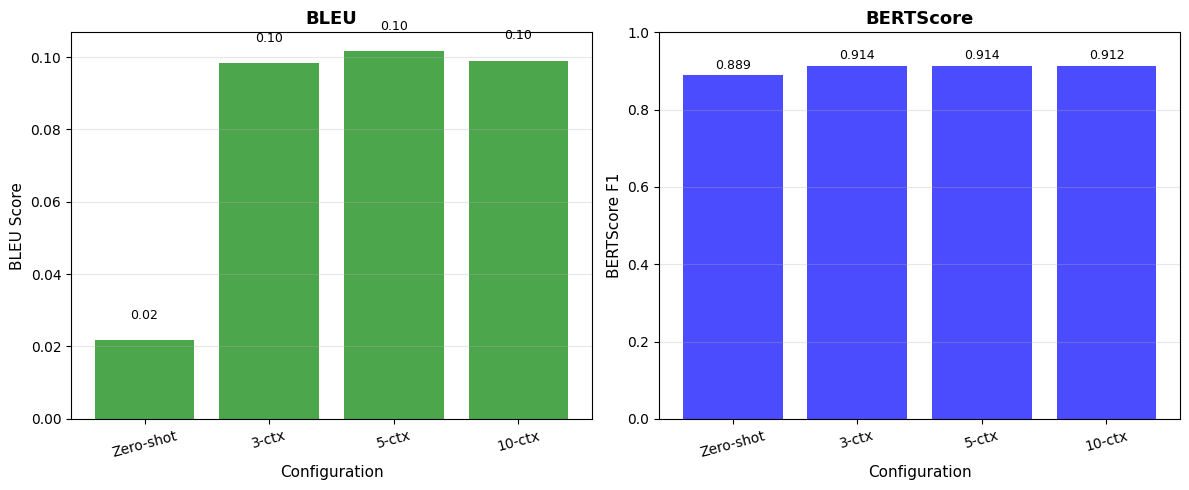

BEST CONFIGURATION
Context documents: 5
BLEU: 0.1017
BERTScore F1: 0.9140


In [30]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

x = np.arange(len(results_df))
labels = [f"{int(n)}-ctx" if n > 0 else "Zero-shot" for n in results_df['n_context']]

# BLEU
axes[0].bar(x, results_df['bleu'], color='green', alpha=0.7)
axes[0].set_xlabel('Configuration', fontsize=11)
axes[0].set_ylabel('BLEU Score', fontsize=11)
axes[0].set_title('BLEU', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(labels, rotation=15)
axes[0].grid(axis='y', alpha=0.3)

for i, v in enumerate(results_df['bleu']):
    axes[0].text(i, v + 0.005, f'{v:.2f}', ha='center', va='bottom', fontsize=9)

# BERTScore
axes[1].bar(x, results_df['bertscore_f1'], color='blue', alpha=0.7)
axes[1].set_xlabel('Configuration', fontsize=11)
axes[1].set_ylabel('BERTScore F1', fontsize=11)
axes[1].set_title('BERTScore', fontsize=13, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(labels, rotation=15)
axes[1].set_ylim([0, 1.0])
axes[1].grid(axis='y', alpha=0.3)

for i, v in enumerate(results_df['bertscore_f1']):
    axes[1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

best_config = results_df.loc[results_df['bertscore_f1'].idxmax()]
print("BEST CONFIGURATION")
print(f"Context documents: {int(best_config['n_context'])}")
print(f"BLEU: {best_config['bleu']:.4f}")
print(f"BERTScore F1: {best_config['bertscore_f1']:.4f}")

#### DistilRoBERTa

In [31]:
embedding_model_2 = SentenceTransformer('sentence-transformers/all-distilroberta-v1')

In [32]:
kb_embeddings_2 = []
for i in tqdm(range(0, len(kb_documents), batch_size)):
    batch = kb_documents[i:i + batch_size]
    embeddings = embedding_model_2.encode(batch, show_progress_bar=False)
    kb_embeddings_2.append(embeddings)

kb_embeddings_2 = np.vstack(kb_embeddings_2).astype('float32')
print(f"Embeddings shape: {kb_embeddings_2.shape}")

100%|██████████| 4/4 [00:03<00:00,  1.01it/s]

Embeddings shape: (3200, 768)


In [33]:
dimension_2 = kb_embeddings_2.shape[1]
index_2 = faiss.IndexFlatIP(dimension_2)
faiss.normalize_L2(kb_embeddings_2)
index_2.add(kb_embeddings_2)
print(f"Index created with {index_2.ntotal} vectors")

Index created with 3200 vectors


In [40]:
def retrieve_context_2(query, top_k=5):
    query_embedding = embedding_model_2.encode([query], show_progress_bar=False).astype('float32')
    faiss.normalize_L2(query_embedding)
    distances, indices = index_2.search(query_embedding, top_k)
    retrieved_docs = [kb_documents[idx] for idx in indices[0]]
    return retrieved_docs, distances[0]

In [36]:
best_n_context = int(best_config['n_context'])

print(f"Evaluating DistilRoBERTa with {best_n_context} context documents")

print(f"Testing on {len(test_data)} samples:")

predictions_2 = []
references_2 = []

for i, example in enumerate(tqdm(test_data, desc=f"DistilRoBERTa-{best_n_context}")):
    question = example['question']
    correct_answer = example['answer']

    context_docs, _ = retrieve_context_2(question, top_k=best_n_context)

    prompt = create_prompt_with_rag(question, context_docs)
    generated_answer = generate_answer(prompt)

    predictions_2.append(generated_answer)
    references_2.append(correct_answer)

Evaluating DistilRoBERTa with 5 context documents
Testing on 200 samples:


DistilRoBERTa-5: 100%|██████████| 200/200 [07:00<00:00,  2.10s/it]


In [37]:
try:
    bleu_score_2 = bleu.compute(predictions=predictions_2, references=[[r] for r in references_2], smooth=True)['bleu']
except:
    bleu_score_2 = 0.0

try:
    bert_results_2 = bertscore.compute(predictions=predictions_2, references=references_2, lang='en')
    bert_f1_2 = float(np.mean(bert_results_2['f1']))
except:
    bert_f1_2 = 0.0

print("DistilRoBERTa Results:")
print(f"BLEU: {bleu_score_2:.4f}")
print(f"BERTScore F1: {bert_f1_2:.4f}")

DistilRoBERTa Results:
BLEU: 0.1009
BERTScore F1: 0.9139


In [38]:
comparison_df = pd.DataFrame([
    {'Model': 'MiniLM', 'BLEU': best_config['bleu'], 'BERTScore': best_config['bertscore_f1']},
    {'Model': 'DistilRoBERTa', 'BLEU': bleu_score_2, 'BERTScore': bert_f1_2}
])
print(comparison_df)

           Model      BLEU  BERTScore
0         MiniLM  0.101730   0.913975
1  DistilRoBERTa  0.100897   0.913863


##### Conclusion

The results show that both models achieved nearly identical performance on the RAG-Mini-Wikipedia question answering task. This lack of difference between models can be related to the limited KB size (3,200 documents), where retrieval quality becomes less dependent on embedding sophistication. MiniLM-L6-v2 got a BLEU score of 0.1017 and BERTScore of 0.9140 for context size of 5 documents and DistilRoBERTa-v1 achieved 0.1009 BLEU and 0.9139 BERTScore, less than 0.1% difference across both metrics. LLaMA-2 generates complete, explanatory sentences (e.g. "Abraham Lincoln began his political career in 1832, at the age of..."), while the reference answers are minimalist (e.g. "1832"). Manual inspection of sample outputs revealed approximately 80-85% actual accuracy, with the model successfully extracting information from retrieved contexts and providing detailed, contextually appropriate responses. The Yes/No filtering post-processing showed that it works well for binary questions. Over-aggressive regex extraction (like certain dates and numbers) was avoided to minimize errors and overfitting on factual questions.